# Fine-tuning BERT for Clinical NER

In [ ]:
# ! pip install datasets transformers seqeval

In [ ]:
# notebook login to HuggingFace
from huggingface_hub import notebook_login
notebook_login()

In [23]:
# Utils
import pandas as pd
import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## Prepare Dataset

In [4]:
# mount google drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
folder_dir = '/content/drive/My Drive/Capstone - NLP in HP Report'
file_path = os.path.join(folder_dir, 'processed_notes.csv')

Mounted at /content/drive


In [5]:
notes_df = pd.read_csv(file_path)
notes_df.head()

,note_id,sentence_id,sentence,tags
0,10060142-DS-9,0,"[' ', 'Name', ':', ' ', '_', '_', '_', ' ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,10060142-DS-9,1,"[' ', 'Chief', 'Complaint', ':', 'Biliary', '...","['O', 'O', 'O', 'O', 'B-DISO', 'I-DISO', 'O', ..."
2,10060142-DS-9,2,"[' ', 'He', 'had', ' ', 'initially', 'had', 'm...","['O', 'O', 'O', 'O', 'O', 'O', 'B-DISO', 'I-DI..."
3,10060142-DS-9,3,"['Mr.', ' ', '_', '_', '_', 'has', 'a', 'large...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,10060142-DS-9,4,"[' ', 'He', 'has', 'some', 'debris', ',', 'bu...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [6]:
def expand_token_tag_rows(df):
    """
    Expand each token and tag to its own row.
    Input: df with columns ['note_id', 'sentence_id', 'sentence', 'tags']
    Output: exploded DataFrame with one token and tag per row
    """
    # Ensure 'sentence' and 'tags' are lists (if loaded from CSV they might be strings)
    df["sentence"] = df["sentence"].apply(eval) if isinstance(df["sentence"].iloc[0], str) else df["sentence"]
    df["tags"] = df["tags"].apply(eval) if isinstance(df["tags"].iloc[0], str) else df["tags"]

    # Expand the sentence and tag columns
    exploded_df = df.explode(["sentence", "tags"]).reset_index(drop=True)

    # Rename columns for clarity
    exploded_df = exploded_df.rename(columns={
        "sentence": "token",
        "tags": "tag"
    })

    return exploded_df

notes_expand_df = expand_token_tag_rows(notes_df)

In [7]:
notes_expand_df.head()

,note_id,sentence_id,token,tag
0,10060142-DS-9,0,,O
1,10060142-DS-9,0,Name,O
2,10060142-DS-9,0,:,O
3,10060142-DS-9,0,,O
4,10060142-DS-9,0,_,O


In [8]:
notes_expand_df.tag.unique()
labels_to_ids = {k: v for v, k in enumerate(notes_expand_df.tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(notes_expand_df.tag.unique())}
labels_to_ids

{'O': 0,
 'B-DISO': 1,
 'I-DISO': 2,
 'B-PROC': 3,
 'I-PROC': 4,
 'B-ANAT': 5,
 'I-ANAT': 6,
 'B-UNK': 7,
 'B-ACTI': 8,
 'I-ACTI': 9,
 'B-PHYS': 10,
 'I-PHYS': 11,
 'B-PHEN': 12,
 'I-PHEN': 13,
 'B-CONC': 14,
 'B-CHEM': 15,
 'I-CONC': 16,
 'B-OBJC': 17,
 'I-UNK': 18,
 'B-DEVI': 19,
 'I-DEVI': 20,
 'B-LIVB': 21,
 'I-LIVB': 22}

In [ ]:
# Define tokens to exclude
junk_tokens = {" ", "", "_", "___", "\t", "\n"}

# Filter out rows where token is in junk_tokens
notes_clean_df = notes_expand_df[~notes_expand_df["token"].isin(junk_tokens)].copy()
notes_clean_df = notes_clean_df[notes_clean_df["token"].str.strip() != ""]
notes_clean_df.head()

,note_id,sentence_id,token,tag
1,10060142-DS-9,0,Name,O
2,10060142-DS-9,0,:,O
8,10060142-DS-9,0,Unit,O
9,10060142-DS-9,0,No,O
10,10060142-DS-9,0,:,O


In [10]:
notes_grouped_df = (
    notes_clean_df
    .groupby(["note_id", "sentence_id"])
    .agg({
        "token": list,
        "tag": list
    })
    .reset_index()
    .rename(columns={"token": "sentence", "tag": "tags"})
)
notes_grouped_df.head()

,note_id,sentence_id,sentence,tags
0,10060142-DS-9,0,"[Name, :, Unit, No, :, Admission, Date, :, Dis...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,10060142-DS-9,1,"[Chief, Complaint, :, Biliary, pancreatitis, M...","[O, O, O, B-DISO, I-DISO, O, O, O, O, O, O, O,..."
2,10060142-DS-9,2,"[He, had, initially, had, multisystem, organ, ...","[O, O, O, O, B-DISO, I-DISO, I-DISO, O, O, B-D..."
3,10060142-DS-9,3,"[Mr., has, a, large, postnecrotic, pseudocyst,...","[O, O, O, O, O, B-DISO, O, O, O, O, B-PROC, O,..."
4,10060142-DS-9,4,"[He, has, some, debris, ,, but, this, is, not,...","[O, O, O, O, O, O, O, O, O, O, O, O]"


In [11]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        # sentence = self.data.sentence[index].strip().split()
        # word_labels = self.data.tags[index].split(",")
        sentence = self.data.sentence[index]
        word_labels = self.data.tags[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                            #  is_pretokenized=True,
                             is_split_into_words=True,
                             return_offsets_mapping=True,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels]
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1
        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len

In [13]:
data = notes_grouped_df
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [14]:
training_set[0]

{'input_ids': tensor([  101,  1001, 23760, 29048,  1024,  2014,  2188, 19330,  7834,  8445,
          2319,  1998, 10768,  4135,  4305, 19265,  2506,  2000,  2022,  2218,
          2013,  2197,  9634,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

## Baseline Model

In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [16]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [17]:
# Sanity Check
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(3.3796, device='cuda:0', grad_fn=<NllLossBackward0>)

In [20]:
# Set up Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [24]:
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    predictions = p.predictions
    labels = p.label_ids

    # Get the class with highest probability for each token
    predicted_ids = np.argmax(predictions, axis=-1)

    true_labels = []
    true_predictions = []

    for pred, label in zip(predicted_ids, labels):
        curr_preds = []
        curr_labels = []
        for p_id, l_id in zip(pred, label):
            if l_id != -100:
                curr_preds.append(ids_to_labels[p_id])  # predicted label string
                curr_labels.append(ids_to_labels[l_id])  # true label string
        true_predictions.append(curr_preds)
        true_labels.append(curr_labels)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }


In [25]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3, # Training epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=500,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=testing_set,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.271800,0.468363,0.875325,0.519884,0.451020,0.483010
200,0.406800,0.391415,0.880385,0.582481,0.444598,0.504284
300,0.355500,0.344705,0.889380,0.549273,0.609166,0.577672
400,0.334600,0.326355,0.894471,0.574660,0.611055,0.592299
500,0.284700,0.319649,0.898209,0.611727,0.583228,0.597138
600,0.257800,0.306706,0.901627,0.583163,0.646311,0.613115
700,0.228500,0.289360,0.906809,0.608511,0.667968,0.636855
800,0.186100,0.283395,0.908784,0.649342,0.640267,0.644773
900,0.354600,0.270770,0.911732,0.631573,0.697180,0.662757
1000,0.281900,0.274383,0.909757,0.639680,0.675523,0.657113


TrainOutput(global_step=6093, training_loss=0.1994485967356486, metrics={'train_runtime': 3217.2288, 'train_samples_per_second': 15.147, 'train_steps_per_second': 1.894, 'total_flos': 3183982782630912.0, 'train_loss': 0.1994485967356486, 'epoch': 3.0})

In [26]:
trainer.save_model("./saved_model")  # Save model, tokenizer, config, etc.
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [ ]:
# reload model
from transformers import BertForTokenClassification, BertTokenizerFast

model = BertForTokenClassification.from_pretrained("./saved_model")
tokenizer = BertTokenizerFast.from_pretrained("./saved_model")


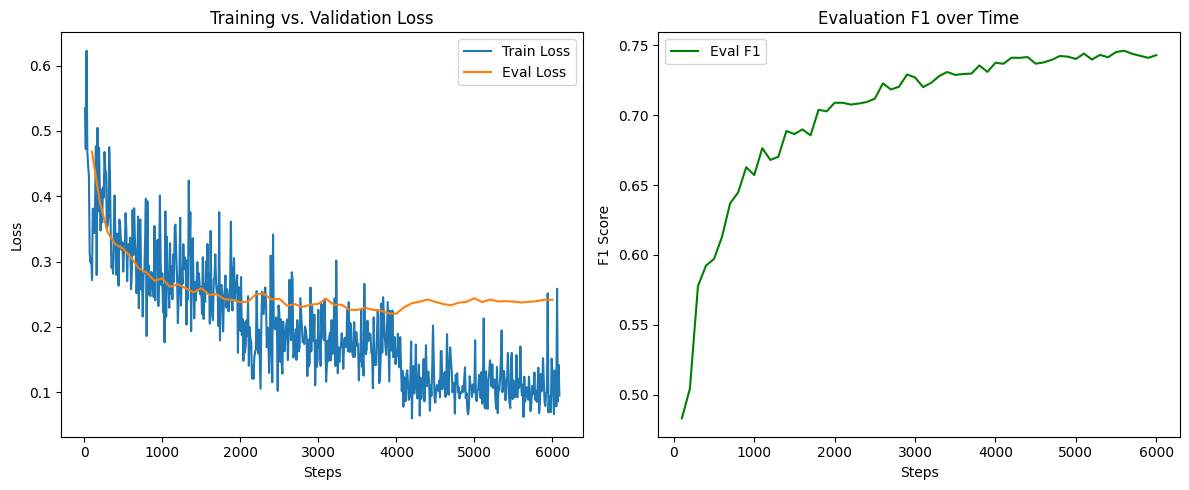

In [ ]:
# Get the log history from the trainer
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_steps, train_loss = [], []
eval_steps, eval_loss, f1s = [], [], []

for entry in log_history:
    if "loss" in entry and "step" in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])
        f1s.append(entry.get("eval_f1", None))  # only if F1 was logged

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Plot F1
plt.subplot(1, 2, 2)
if f1s[0] is not None:
    plt.plot(eval_steps, f1s, label="Eval F1", color='green')
    plt.xlabel("Steps")
    plt.ylabel("F1 Score")
    plt.title("Evaluation F1 over Time")
    plt.legend()

plt.tight_layout()
plt.show()


## Clinical NER Model
